# Taks
- benchmark: K-means
- innitialization: random vs k-means
- modalities: T1-w vs T1-w+FLAIR
- metrics: DSC, num iterations, comp.time

# Get brain tissues mask from the ground truth

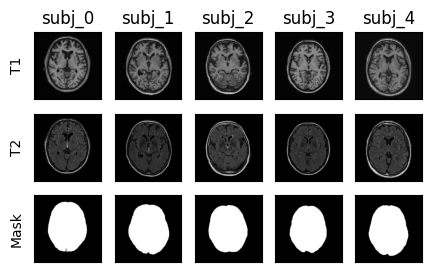

In [11]:
import cv2
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import utils as utils

data_path = Path('/home/jseia/Desktop/MAIA/Clases/spain/misa/misa_lab/data/P2_data')

# Get brain masks from labels
for i in tqdm(range(5)):
    path = data_path / f'{i+1}/LabelsForTesting.nii'
    brain_mask = sitk.ReadImage(path)
    bm_array = sitk.GetArrayFromImage(brain_mask)
    bm_array = np.where(bm_array > 0, 255, 0).astype('uint8')
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    bm_array = cv2.morphologyEx(bm_array, cv2.MORPH_CLOSE, se)
    img = sitk.GetImageFromArray(np.where(bm_array>0, 255, 0))
    img.SetDirection(brain_mask.GetDirection())
    img.SetOrigin(brain_mask.GetOrigin())
    img.SetSpacing(brain_mask.GetSpacing())
    path = data_path / f'{i+1}/brain_mask.nii'
    sitk.WriteImage(img, path)
    
slice_n = 20
fig, ax = plt.subplots(3, 5, figsize=(5, 3))
for i in range(5):
    t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    bm = sitk.GetArrayFromImage(bm)
    t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
    t2_array = utils.min_max_norm(t2_array, 255, 'uint8')
    
    titles = ['T1', 'T2', 'Mask']
    for k, img in enumerate([t1_array, t2_array, bm]):
        if k == 0:
            ax[k, i].set_title(f'subj_{i}')
        ax[k, i].set_xticks([])
        ax[k, i].set_yticks([])
        if i == 0:
            ax[k, i].set_ylabel(titles[k])
        ax[k, i].imshow(img[slice_n, :, :], cmap='gray')
plt.show()

# Compare results of different models

Define a set of necessary functions to run the experiments

In [12]:
import utils
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
from pathlib import Path
from sklearn.cluster import KMeans
from src import ExpectationMaximization
from scipy.ndimage import median_filter
import seaborn as sns
from varname import nameof
from typing import List

In [18]:
def brain_tissue_segmentation(
    t1, t2, brain_mask, mode, mean_init='kmeans', hard_em=True
):
    # T1+T2
    t1_vector = t1[brain_mask == 255].flatten()
    t2_vector = t2[brain_mask == 255].flatten()
    data = np.array([t1_vector, t2_vector]).T
    if mode == 'em':
        model = ExpectationMaximization(
            n_components=3, mean_init=mean_init,
            priors='non_informative', verbose=False, plot_rate=None,
            hard_em=hard_em)
    else:
        model = KMeans(n_clusters=3, random_state=420)
    start = time.time()
    preds = model.fit_predict(data)
    t_t1_t2 = time.time() - start
    predictions = brain_mask.flatten()
    predictions[predictions==255] = preds + 1
    t1_t2_seg_res = predictions.reshape(t1.shape)
    
    # T1
    data = np.array(t1_vector)[:, np.newaxis]
    if mode == 'em':
        model = ExpectationMaximization(
            n_components=3, mean_init=mean_init,
            priors='non_informative', verbose=False, plot_rate=None,
            hard_em=hard_em)
    else:
        model = KMeans(n_clusters=3, random_state=420)
    start = time.time()
    preds = model.fit_predict(data)
    t_t1 = time.time() - start
    predictions = brain_mask.flatten()
    predictions[predictions==255] = preds + 1
    t1_seg_res = predictions.reshape(t1.shape)
    return t1_seg_res, t1_t2_seg_res, t_t1, t_t1_t2


def dice_score(gt, pred):
    classes = np.unique(gt[gt != 0])
    dice = np.zeros((len(classes)))
    for i in classes:
        bin_pred = np.where(pred == i, 1, 0)
        bin_gt = np.where(gt == i, 1, 0)
        dice[i-1] = np.sum(bin_pred[bin_gt == 1]) * 2.0 / (np.sum(bin_pred) + np.sum(bin_gt))
    return dice.tolist()


def plots(volumes, names, slice_n = 20):
    n = len(volumes)
    fig, ax = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):
        cmap = 'gray' if len(np.unique(volumes[i])) > 4 else 'viridis'
        ax[i].set_title(names[i])
        ax[i].imshow(volumes[i][slice_n, :, :], cmap=cmap)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

    
def save_segementations(volume, reference, filepath):
    # Save image
    img = sitk.GetImageFromArray(volume)
    img.SetDirection(reference.GetDirection())
    img.SetOrigin(reference.GetOrigin())
    img.SetSpacing(reference.GetSpacing())
    sitk.WriteImage(img, filepath)

    
def complete_figure(img_names, ylabels, slice_n = 25):
    fig, ax = plt.subplots(len(img_names), 5, figsize=(10, 14))
    for i in range(5):
        for j, img_name in enumerate(img_names):
            img = sitk.ReadImage(data_path / f'{i+1}/{img_name}')
            img_array = sitk.GetArrayFromImage(img)
            if j == len(img_names)-1:
                ax[j, i].set_xlabel(f'Subject {i+1}')
            if j in [0, 1]:
                ax[j, i].imshow(img_array[slice_n, :, :], cmap='gray')
            else:
                ax[j, i].imshow(img_array[slice_n, :, :])
            ax[j, i].set_xticks([]) 
            ax[j, i].set_yticks([]) 
            if i == 0:
                ax[j, i].set_ylabel(ylabels[j])
    plt.show()

## Compare the different initializations for EM

-------------------- Subject N°1 --------------------


  6%|▌         | 6/100 [00:01<00:20,  4.56it/s]


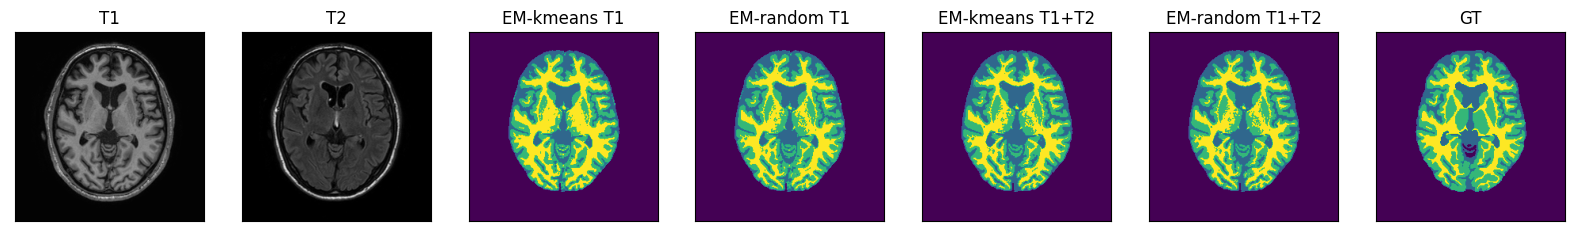

-------------------- Subject N°2 --------------------


  5%|▌         | 5/100 [00:01<00:20,  4.71it/s]


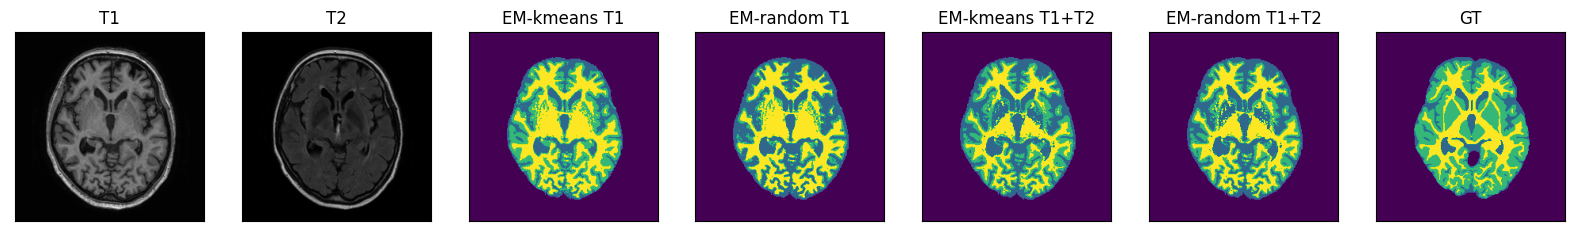

-------------------- Subject N°3 --------------------


 14%|█▍        | 14/100 [00:02<00:15,  5.48it/s]


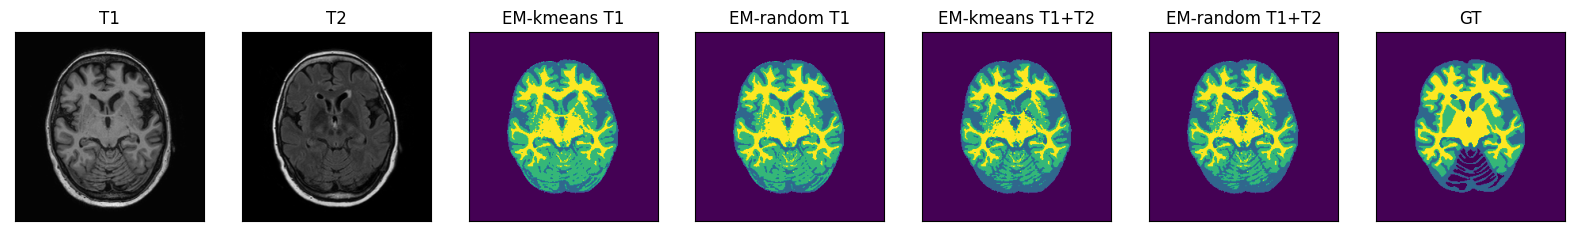

-------------------- Subject N°4 --------------------


 12%|█▏        | 12/100 [00:02<00:15,  5.63it/s]


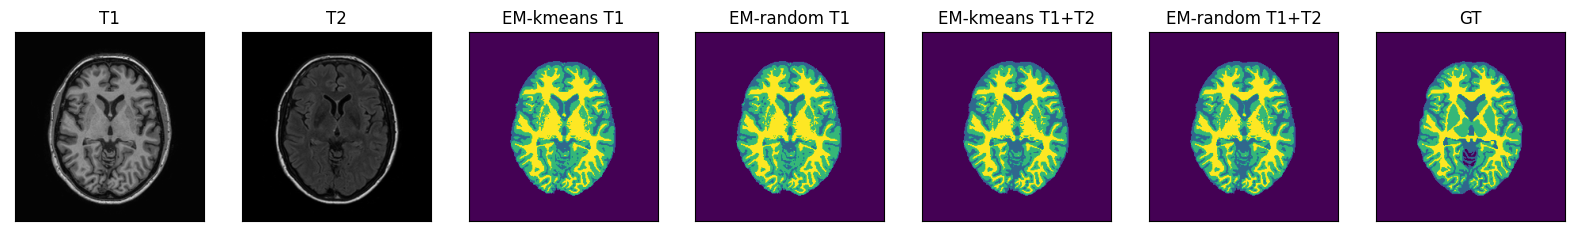

-------------------- Subject N°5 --------------------


 18%|█▊        | 18/100 [00:03<00:15,  5.38it/s]


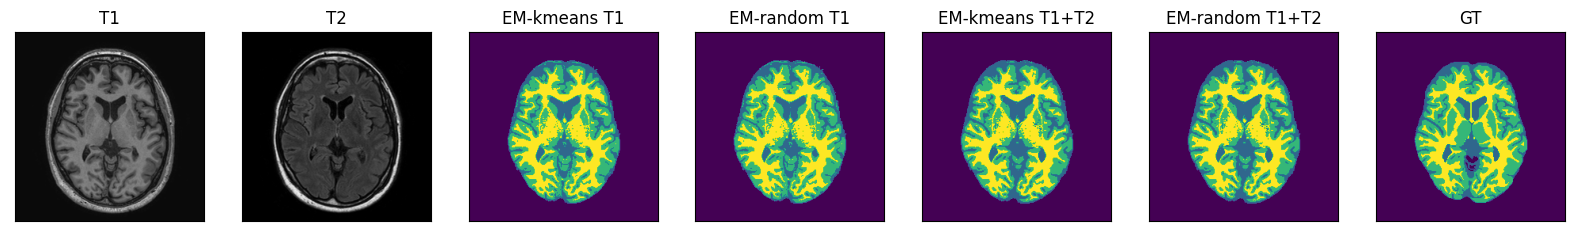

CSF        GM        WM modalities  subject model    init       time
0   0.796468  0.717748  0.822407         T1        0    EM  kmeans   2.945995
1   0.814516  0.755502  0.826777      T1+T2        0    EM  kmeans  10.609854
2   0.802471  0.735131  0.827708         T1        0    EM  random   1.439561
3   0.814133  0.755187  0.826597      T1+T2        0    EM  random   6.939324
4   0.777045  0.674134  0.717289         T1        1    EM  kmeans   1.743035
5   0.703595  0.697598  0.756481      T1+T2        1    EM  kmeans  16.240453
6   0.654321  0.461754  0.709224         T1        1    EM  random   1.197509
7   0.700815  0.658552  0.731497      T1+T2        1    EM  random   8.041409
8   0.763501  0.717940  0.821691         T1        2    EM  kmeans   2.692484
9   0.763554  0.724191  0.818056      T1+T2        2    EM  kmeans   9.188188
10  0.771554  0.720974  0.824081         T1        2    EM  random   2.670275
11  0.763461  0.724358  0.819099      T1+T2        2    EM  random   6.578896
12  0.794923  0.751014  0.817061         T1        3    EM  kmeans   2.646615
13  0.813653  0.771190  0.825987      T1+T2        3    EM  kmeans  10.183211
14  0.783474  0.745330  0.817078         T1        3    EM  random   2.260278
15  0.813563  0.771353  0.826042      T1+T2        3    EM  random   8.895562
16  0.763798  0.770293  0.838442         T1        4    EM  kmeans   3.526754
17  0.755124  0.771671  0.839919      T1+T2        4    EM  kmeans   8.021945
18  0.763848  0.771426  0.838468         T1        4    EM  random   3.458645
19  0.755108  0.771697  0.839610      T1+T2        4    EM  random   6.990726

In [36]:
data_path = Path.cwd().parent / 'data/P2_data'

dice_scores = []
for i in range(5):
    print(f'{"-"*20} Subject N°{i + 1} {"-"*20}')
    
    # Load images
    t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    gt = sitk.ReadImage(data_path / f'{i+1}/LabelsForTesting.nii')
    bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')
    spm_seg_t1_t2 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1_t2.nii')
    spm_seg_t1 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1.nii')

    # Get arrays
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    gt_array = sitk.GetArrayFromImage(gt)
    bm = sitk.GetArrayFromImage(bm)
    spm_seg_t1_t2_array = sitk.GetArrayFromImage(spm_seg_t1_t2)
    spm_seg_t1_array = sitk.GetArrayFromImage(spm_seg_t1)

    # Cast images de uint8
    t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
    t2_array = utils.min_max_norm(t2_array, 255, 'uint8')

    # Segement Brain
    t1_seg_res_em_km, t1_t2_seg_res_em_km, t_t1_em_km, t_t1_t2_em_km = \
        brain_tissue_segmentation(t1_array, t2_array, bm, 'em', 'kmeans', True)
    t1_seg_res_em_rnd, t1_t2_seg_res_em_rnd, t_t1_em_rnd, t_t1_t2_em_rnd = \
        brain_tissue_segmentation(t1_array, t2_array, bm, 'em', 'random', True)

    # Correct labels to match groun truth
    t1_seg_res_em_km = utils.match_pred_w_gt(t1_seg_res_em_km, gt_array, t1_array)
    t1_t2_seg_res_em_km = utils.match_pred_w_gt(t1_t2_seg_res_em_km, gt_array, t1_array, t2_array)
    t1_seg_res_em_rnd = utils.match_pred_w_gt(t1_seg_res_em_rnd, gt_array, t1_array)
    t1_t2_seg_res_em_rnd = utils.match_pred_w_gt(t1_t2_seg_res_em_rnd, gt_array, t1_array, t2_array)
    # spm_seg_t1_t2_array = utils.match_pred_w_gt(spm_seg_t1_t2_array, gt_array, t1_array, t2_array)
    # spm_seg_t1_array = utils.match_pred_w_gt(spm_seg_t1_array, gt_array, t1_array, t2_array)

    # Get dice scores
    dice_scores.append(dice_score(gt_array, t1_seg_res_em_km) + ['T1', i, 'EM', 'kmeans', t_t1_em_km])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_em_km) + ['T1+T2', i, 'EM', 'kmeans', t_t1_t2_em_km])
    dice_scores.append(dice_score(gt_array, t1_seg_res_em_rnd) + ['T1', i, 'EM', 'random', t_t1_em_rnd])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_em_rnd) + ['T1+T2', i, 'EM', 'random', t_t1_t2_em_rnd])
    # dice_scores.append(dice_score(gt_array, spm_seg_t1_array) + ['T1', i, 'SPM', 0])
    # dice_scores.append(dice_score(gt_array, spm_seg_t1_t2_array) + ['T1+T2', i, 'SPM', 0])
    
    # Plot
    volumes = [t1_array, t2_array, t1_seg_res_em_km, t1_seg_res_em_rnd,
               t1_t2_seg_res_em_km, t1_t2_seg_res_em_rnd, gt_array]
    names = ['T1', 'T2', 'EM-kmeans T1', 'EM-random T1', 'EM-kmeans T1+T2', 'EM-random T1+T2', 'GT']
    plots(volumes, names, slice_n = 20)
    
    # break
    # Save images
    save_segementations(t1_seg_res_em_km, spm_seg_t1_t2, data_path / f'{i+1}/em_km_seg_t1.nii')
    save_segementations(t1_seg_res_em_rnd, spm_seg_t1_t2, data_path / f'{i+1}/em_rnd_seg_t1.nii')
    save_segementations(t1_t2_seg_res_em_km, spm_seg_t1_t2, data_path / f'{i+1}/em_km_seg_t1_t2.nii')
    save_segementations(t1_t2_seg_res_em_rnd, spm_seg_t1_t2, data_path / f'{i+1}/em_rnd_seg_t1_t2.nii')

dice_scores = pd.DataFrame(data=dice_scores, columns = ['CSF', 'GM', 'WM', 'modalities', 'subject', 'model', 'init', 'time'])
dice_scores.to_csv('dice_scores_init.csv')
dice_scores

### Visualize all results

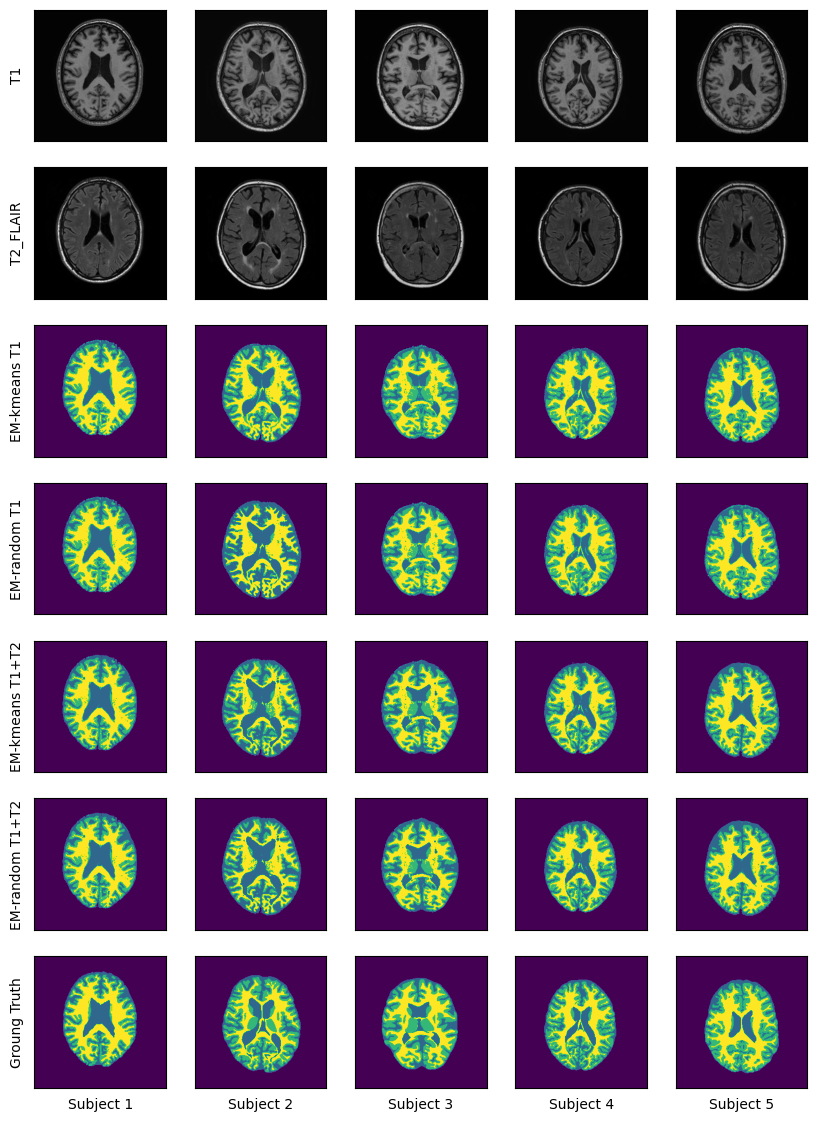

In [37]:
img_names = [
    'T1.nii', 'T2_FLAIR.nii', 'em_km_seg_t1.nii', 'em_rnd_seg_t1.nii',
    'em_km_seg_t1_t2.nii', 'em_rnd_seg_t1_t2.nii', 'LabelsForTesting.nii'
]
ylabels = [
    'T1', 'T2_FLAIR', 'EM-kmeans T1', 'EM-random T1',
    'EM-kmeans T1+T2', 'EM-random T1+T2', 'Groung Truth'
]
complete_figure(img_names, ylabels, slice_n = 25)

### Get boxplots and tables

In [38]:
df = pd.melt(dice_scores, id_vars=['modalities', 'subject', 'model', 'init', 'time'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df['model'] = df['model'].str.upper()
df.columns = ['Modalities', 'Subject', 'Model', 'Init', 'Time', 'Tissue', 'Dice']

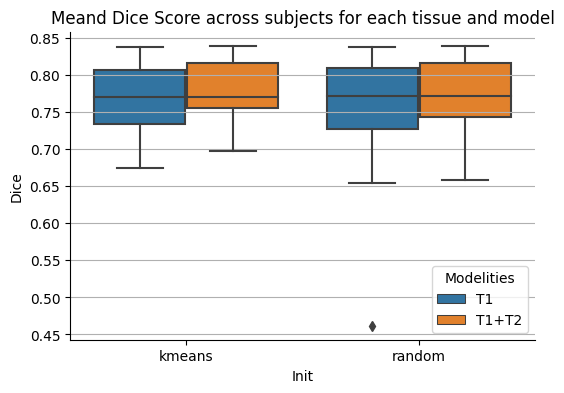

In [39]:
plt.figure(figsize=(6,4))
plt.title('Meand Dice Score across subjects for each tissue and model')
sns.boxplot(data=df, x="Init", y="Dice", hue="Modalities")
sns.despine()
plt.grid(axis='y')
plt.legend(loc='lower right', title='Modelities')
plt.show()

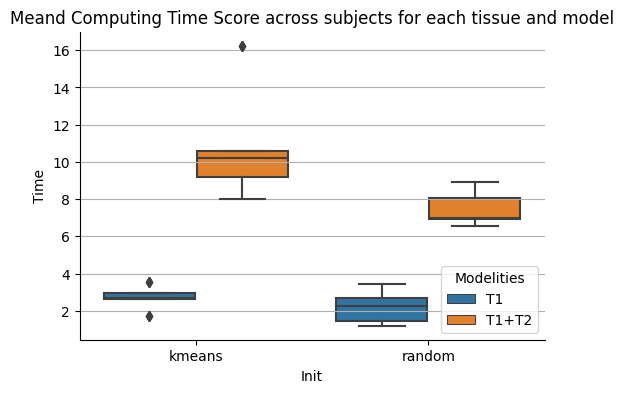

In [40]:
plt.figure(figsize=(6,4))
plt.title('Meand Computing Time Score across subjects for each tissue and model')
sns.boxplot(data=df, x="Init", y="Time", hue="Modalities")
sns.despine()
plt.grid(axis='y')
plt.legend(loc='lower right', title='Modelities')
plt.show()

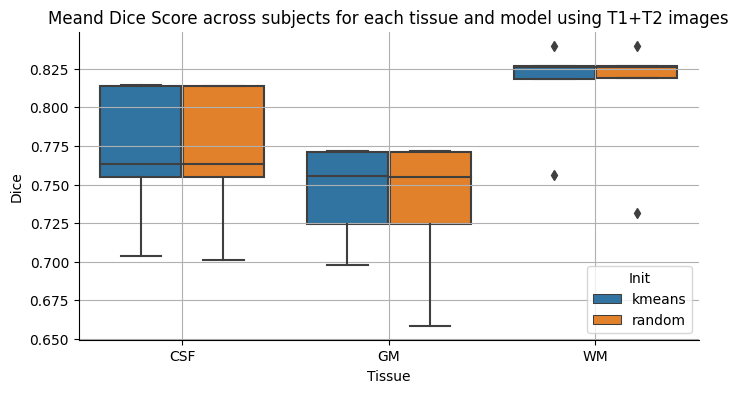

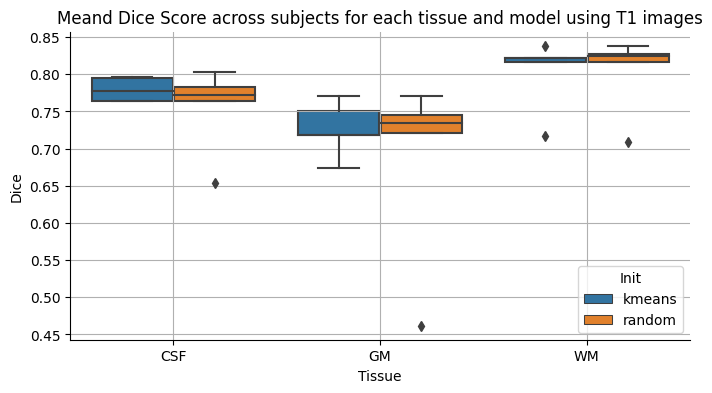

In [41]:
df_ = df.loc[df.Modalities == 'T1+T2']
plt.figure(figsize=(8,4))
plt.title('Meand Dice Score across subjects for each tissue and model using T1+T2 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Init")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Init')
plt.show()

df_ = df.loc[df.Modalities == 'T1']
plt.figure(figsize=(8,4))
plt.title('Meand Dice Score across subjects for each tissue and model using T1 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Init")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Init')
plt.show()

# Compare hard vs fuzzy

-------------------- Subject N°1 --------------------


 25%|██▌       | 25/100 [00:04<00:13,  5.68it/s]


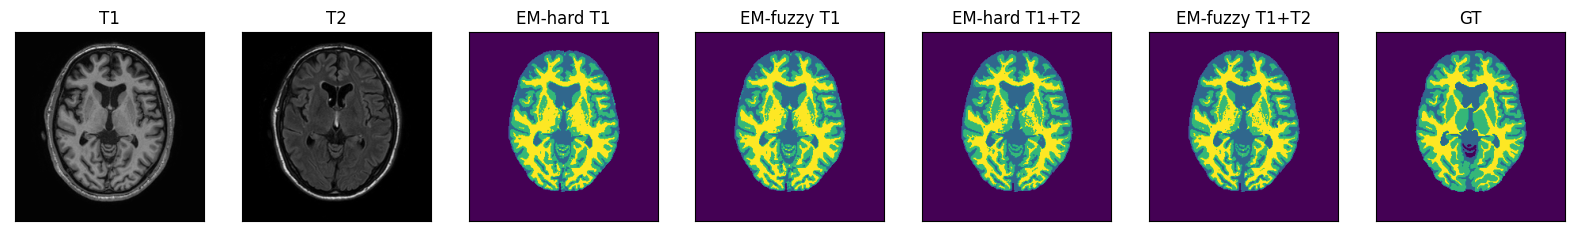

-------------------- Subject N°2 --------------------


 32%|███▏      | 32/100 [00:05<00:12,  5.38it/s]


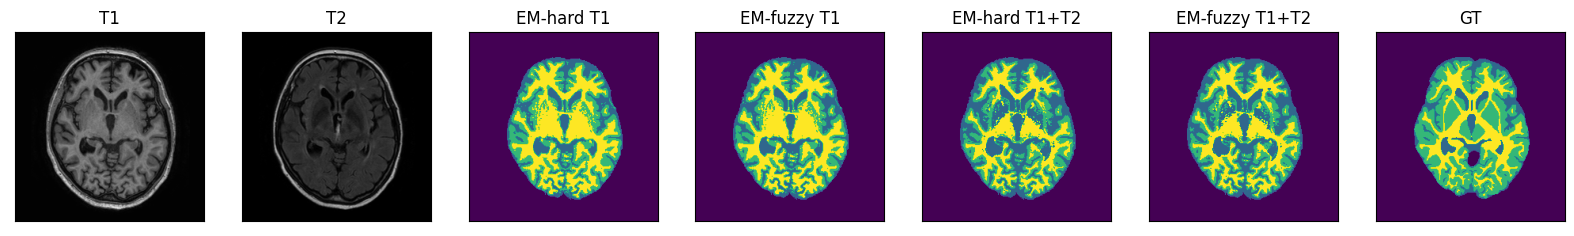

-------------------- Subject N°3 --------------------


 29%|██▉       | 29/100 [00:05<00:12,  5.66it/s]


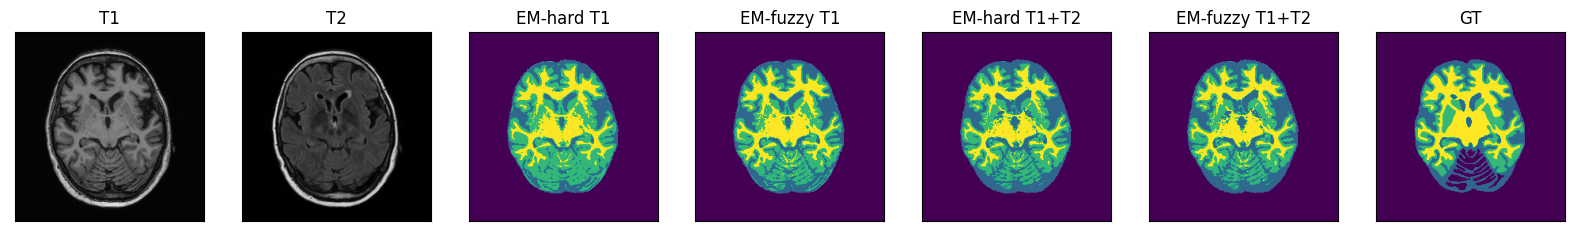

-------------------- Subject N°4 --------------------


 27%|██▋       | 27/100 [00:04<00:12,  5.99it/s]


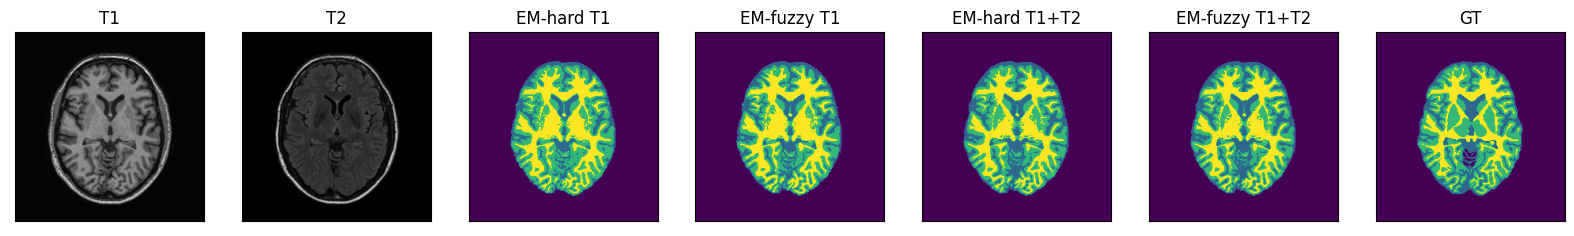

-------------------- Subject N°5 --------------------


 26%|██▌       | 26/100 [00:04<00:13,  5.63it/s]


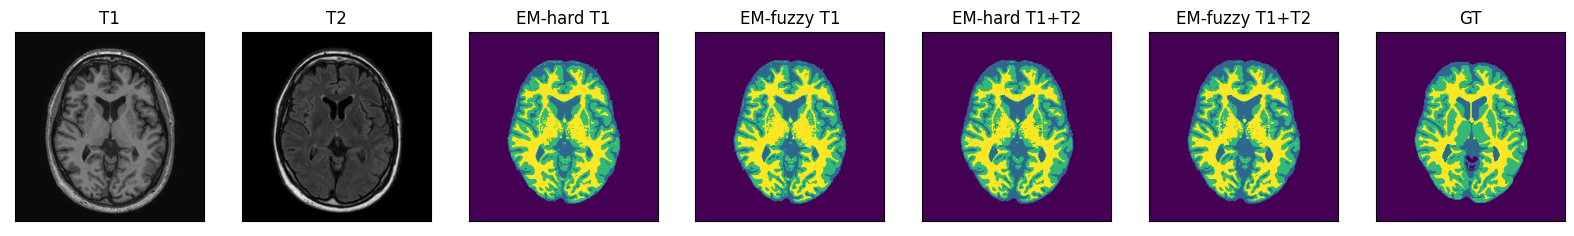

CSF        GM        WM modalities  subject model    init variant  \
0   0.796468  0.717748  0.822407         T1        0    EM  kmeans    hard   
1   0.814516  0.755502  0.826777      T1+T2        0    EM  kmeans    hard   
2   0.805559  0.723507  0.822372         T1        0    EM  kmeans   fuzzy   
3   0.812962  0.750800  0.829598      T1+T2        0    EM  kmeans   fuzzy   
4   0.777045  0.674134  0.717289         T1        1    EM  kmeans    hard   
5   0.703595  0.697598  0.756481      T1+T2        1    EM  kmeans    hard   
6   0.762473  0.659434  0.717393         T1        1    EM  kmeans   fuzzy   
7   0.712489  0.696657  0.754543      T1+T2        1    EM  kmeans   fuzzy   
8   0.763501  0.717940  0.821691         T1        2    EM  kmeans    hard   
9   0.763554  0.724191  0.818056      T1+T2        2    EM  kmeans    hard   
10  0.775999  0.715772  0.824139         T1        2    EM  kmeans   fuzzy   
11  0.760983  0.720366  0.820201      T1+T2        2    EM  kmeans   fuzzy   
12  0.794923  0.751014  0.817061         T1        3    EM  kmeans    hard   
13  0.813653  0.771190  0.825987      T1+T2        3    EM  kmeans    hard   
14  0.814173  0.746547  0.802808         T1        3    EM  kmeans   fuzzy   
15  0.812009  0.762138  0.820842      T1+T2        3    EM  kmeans   fuzzy   
16  0.763798  0.770293  0.838442         T1        4    EM  kmeans    hard   
17  0.755124  0.771671  0.839919      T1+T2        4    EM  kmeans    hard   
18  0.754041  0.752152  0.827856         T1        4    EM  kmeans   fuzzy   
19  0.741010  0.758837  0.838845      T1+T2        4    EM  kmeans   fuzzy   

        time  
0   3.526754  
1   8.021945  
2   3.458645  
3   6.990726  
4   3.526754  
5   8.021945  
6   3.458645  
7   6.990726  
8   3.526754  
9   8.021945  
10  3.458645  
11  6.990726  
12  3.526754  
13  8.021945  
14  3.458645  
15  6.990726  
16  3.526754  
17  8.021945  
18  3.458645  
19  6.990726

In [42]:
data_path = Path.cwd().parent / 'data/P2_data'

dice_scores = []
for i in range(5):
    print(f'{"-"*20} Subject N°{i + 1} {"-"*20}')
    
    # Load images
    t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    gt = sitk.ReadImage(data_path / f'{i+1}/LabelsForTesting.nii')
    bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')
    spm_seg_t1_t2 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1_t2.nii')
    spm_seg_t1 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1.nii')

    # Get arrays
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    gt_array = sitk.GetArrayFromImage(gt)
    bm = sitk.GetArrayFromImage(bm)
    spm_seg_t1_t2_array = sitk.GetArrayFromImage(spm_seg_t1_t2)
    spm_seg_t1_array = sitk.GetArrayFromImage(spm_seg_t1)

    # Cast images de uint8
    t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
    t2_array = utils.min_max_norm(t2_array, 255, 'uint8')

    # Segement Brain
    t1_seg_res_em_km_h, t1_t2_seg_res_em_km_h, t_t1_em_km_h, t_t1_t2_em_km_h = \
        brain_tissue_segmentation(t1_array, t2_array, bm, 'em', 'kmeans', True)
    t1_seg_res_em_km_f, t1_t2_seg_res_em_km_f, t_t1_em_km_f, t_t1_t2_em_km_f = \
        brain_tissue_segmentation(t1_array, t2_array, bm, 'em', 'kmeans', False)

    # Correct labels to match groun truth
    t1_seg_res_em_km_h = utils.match_pred_w_gt(t1_seg_res_em_km_h, gt_array, t1_array)
    t1_t2_seg_res_em_km_h = utils.match_pred_w_gt(t1_t2_seg_res_em_km_h, gt_array, t1_array, t2_array)
    t1_seg_res_em_km_f = utils.match_pred_w_gt(t1_seg_res_em_km_f, gt_array, t1_array)
    t1_t2_seg_res_em_km_f = utils.match_pred_w_gt(t1_t2_seg_res_em_km_f, gt_array, t1_array, t2_array)

    # Get dice scores
    dice_scores.append(dice_score(gt_array, t1_seg_res_em_km_h) + ['T1', i, 'EM', 'kmeans', 'hard', t_t1_em_km])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_em_km_h) + ['T1+T2', i, 'EM', 'kmeans', 'hard', t_t1_t2_em_km])
    dice_scores.append(dice_score(gt_array, t1_seg_res_em_km_f) + ['T1', i, 'EM', 'kmeans', 'fuzzy', t_t1_em_rnd])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_em_km_f) + ['T1+T2', i, 'EM', 'kmeans', 'fuzzy', t_t1_t2_em_rnd])
    
    # Plot
    volumes = [t1_array, t2_array, t1_seg_res_em_km_h, t1_seg_res_em_km_f,
               t1_t2_seg_res_em_km_h, t1_t2_seg_res_em_km_f, gt_array]
    names = ['T1', 'T2', 'EM-hard T1', 'EM-fuzzy T1', 'EM-hard T1+T2', 'EM-fuzzy T1+T2', 'GT']
    plots(volumes, names, slice_n = 20)
    
    # break
    # Save images
    save_segementations(t1_seg_res_em_km_h, spm_seg_t1_t2, data_path / f'{i+1}/em_km_h_seg_t1.nii')
    save_segementations(t1_seg_res_em_km_f, spm_seg_t1_t2, data_path / f'{i+1}/em_km_f_seg_t1.nii')
    save_segementations(t1_t2_seg_res_em_km_h, spm_seg_t1_t2, data_path / f'{i+1}/em_km_h_seg_t1_t2.nii')
    save_segementations(t1_t2_seg_res_em_km_f, spm_seg_t1_t2, data_path / f'{i+1}/em_km_f_seg_t1_t2.nii')

dice_scores = pd.DataFrame(data=dice_scores, columns = ['CSF', 'GM', 'WM', 'modalities', 'subject', 'model', 'init', 'variant', 'time'])
dice_scores.to_csv('dice_scores_hard_fuzzy.csv')
dice_scores

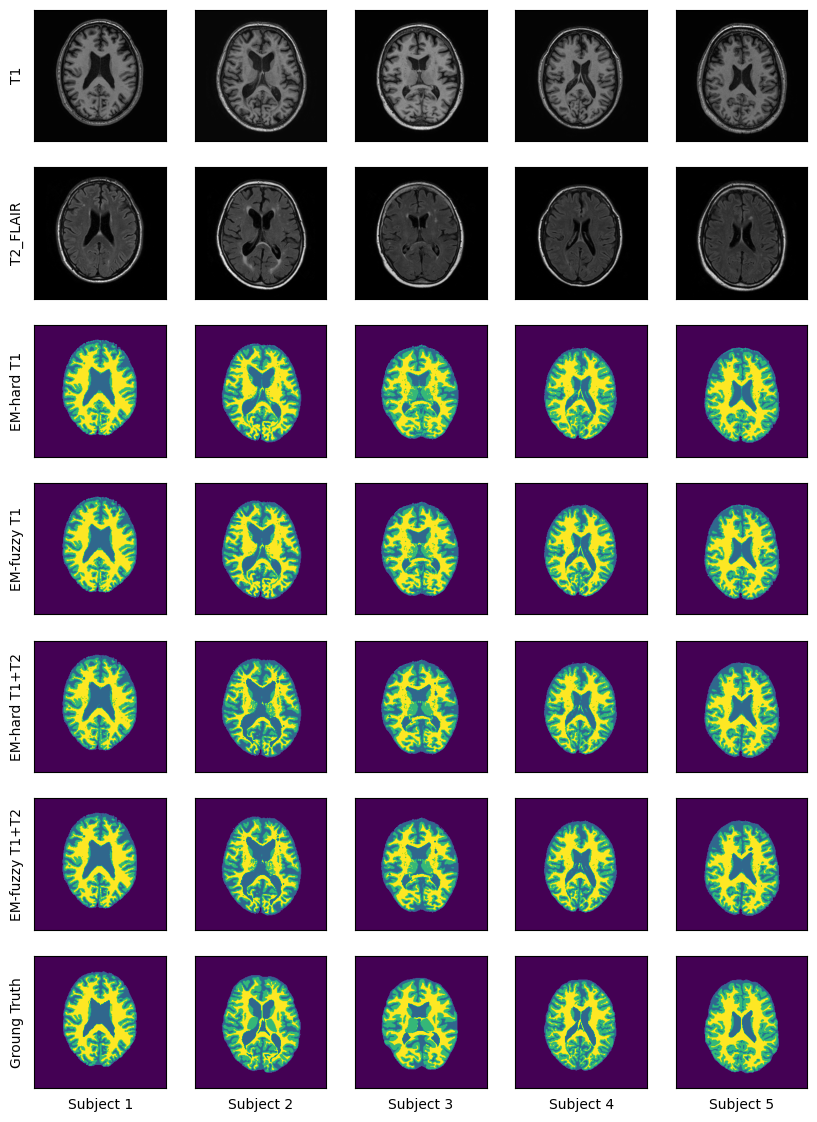

In [53]:
img_names = [
    'T1.nii', 'T2_FLAIR.nii', 'em_km_h_seg_t1.nii', 'em_km_f_seg_t1.nii',
    'em_km_h_seg_t1_t2.nii', 'em_km_f_seg_t1_t2.nii', 'LabelsForTesting.nii'
]
ylabels = [
    'T1', 'T2_FLAIR', 'EM-hard T1', 'EM-fuzzy T1',
    'EM-hard T1+T2', 'EM-fuzzy T1+T2', 'Groung Truth'
]
complete_figure(img_names, ylabels, slice_n = 25)

In [54]:
df = pd.melt(dice_scores, id_vars=['modalities', 'subject', 'model', 'init', 'variant', 'time'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df['model'] = df['model'].str.upper()
df.columns = ['Modalities', 'Subject', 'Model', 'Init', 'Variant', 'Time', 'Tissue', 'Dice']

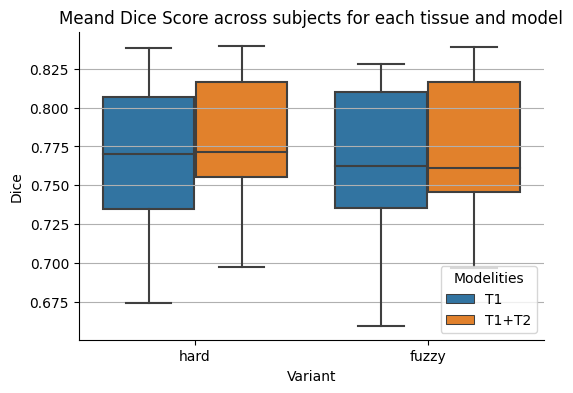

In [55]:
plt.figure(figsize=(6,4))
plt.title('Meand Dice Score across subjects for each tissue and model')
sns.boxplot(data=df, x="Variant", y="Dice", hue="Modalities")
sns.despine()
plt.grid(axis='y')
plt.legend(loc='lower right', title='Modelities')
plt.show()

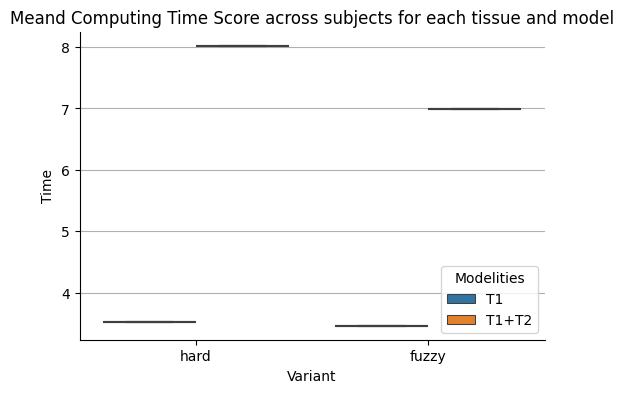

In [56]:
plt.figure(figsize=(6,4))
plt.title('Meand Computing Time Score across subjects for each tissue and model')
sns.boxplot(data=df, x="Variant", y="Time", hue="Modalities")
sns.despine()
plt.grid(axis='y')
plt.legend(loc='lower right', title='Modelities')
plt.show()

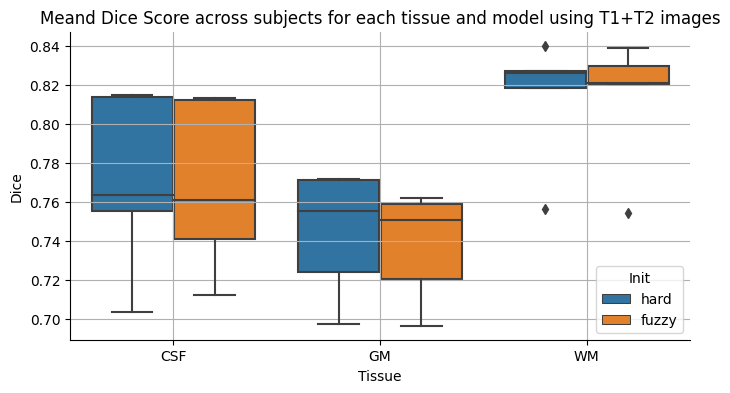

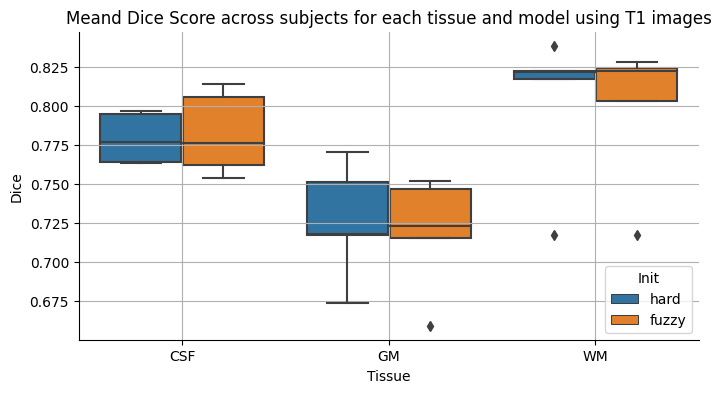

In [57]:
df_ = df.loc[df.Modalities == 'T1+T2']
plt.figure(figsize=(8,4))
plt.title('Meand Dice Score across subjects for each tissue and model using T1+T2 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Variant")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Init')
plt.show()

df_ = df.loc[df.Modalities == 'T1']
plt.figure(figsize=(8,4))
plt.title('Meand Dice Score across subjects for each tissue and model using T1 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Variant")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Init')
plt.show()

# Compare EM-best vs KM

kmeans initialization has less dispersion, and almost the same mean, so it is chosen as best configuration

-------------------- Subject N°1 --------------------


  7%|▋         | 7/100 [00:01<00:18,  5.14it/s]


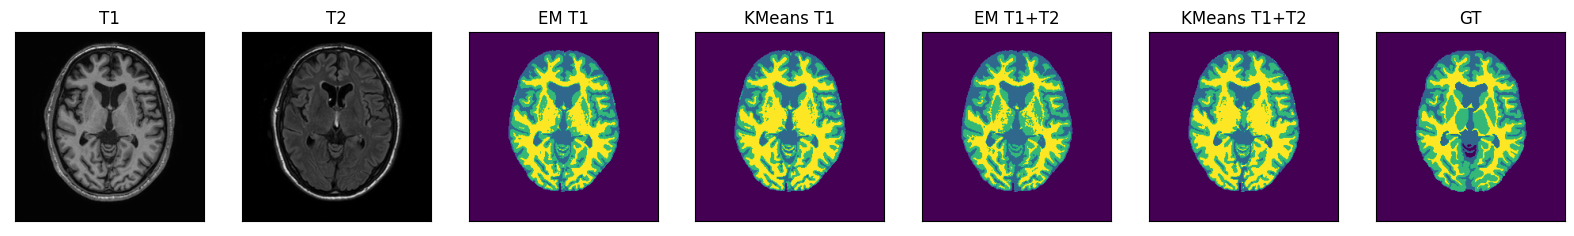

-------------------- Subject N°2 --------------------


  3%|▎         | 3/100 [00:00<00:21,  4.46it/s]


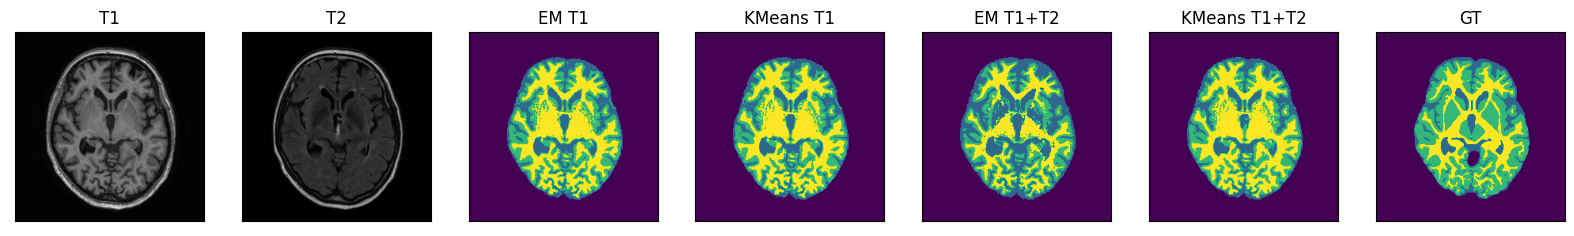

-------------------- Subject N°3 --------------------


 10%|█         | 10/100 [00:02<00:18,  4.98it/s]


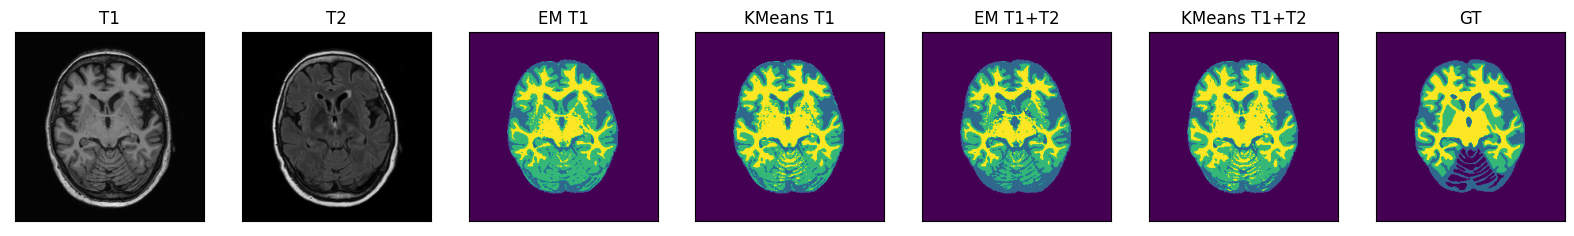

-------------------- Subject N°4 --------------------


 10%|█         | 10/100 [00:01<00:15,  5.80it/s]


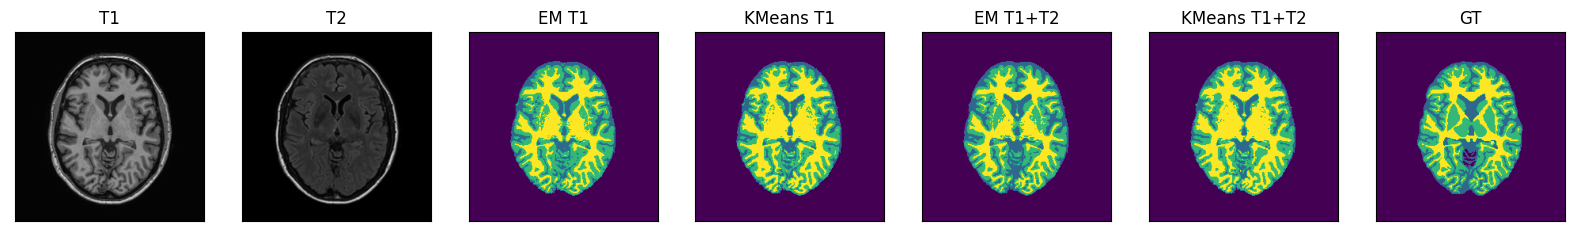

-------------------- Subject N°5 --------------------


 10%|█         | 10/100 [00:02<00:18,  4.76it/s]


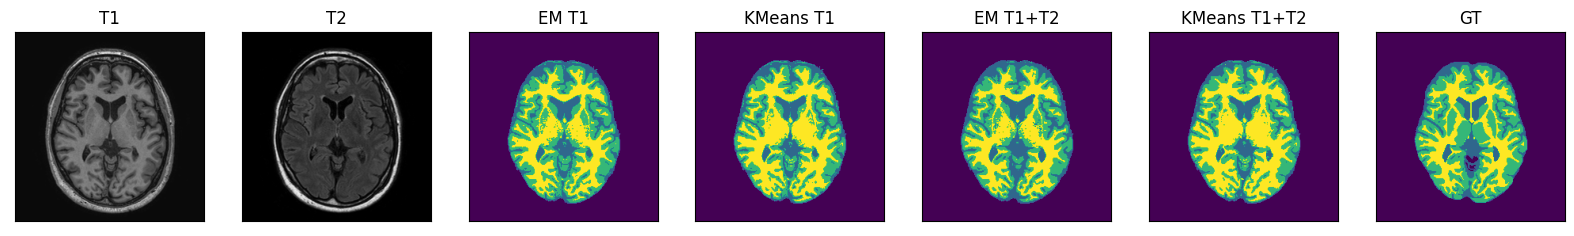

CSF        GM        WM modalities  subject model       time
0   0.789775  0.668078  0.780703         T1        0    KM   1.162511
1   0.749354  0.636516  0.764652      T1+T2        0    KM   2.631393
2   0.796468  0.717748  0.822407         T1        0    EM   2.542764
3   0.814516  0.755502  0.826777      T1+T2        0    EM  10.540609
4   0.797686  0.753831  0.825104         T1        0   SPM   0.000000
5   0.798009  0.760439  0.830556      T1+T2        0   SPM   0.000000
6   0.777177  0.664363  0.708078         T1        1    KM   0.827715
7   0.783883  0.661234  0.698868      T1+T2        1    KM   2.471228
8   0.777045  0.674134  0.717289         T1        1    EM   1.984000
9   0.703595  0.697598  0.756481      T1+T2        1    EM  14.779492
10  0.749920  0.704101  0.756600         T1        1   SPM   0.000000
11  0.738693  0.729509  0.760457      T1+T2        1   SPM   0.000000
12  0.757811  0.670062  0.787153         T1        2    KM   0.969326
13  0.741984  0.643569  0.769900      T1+T2        2    KM   3.358522
14  0.763501  0.717940  0.821691         T1        2    EM   3.400969
15  0.763554  0.724191  0.818056      T1+T2        2    EM   9.266469
16  0.780763  0.731211  0.822073         T1        2   SPM   0.000000
17  0.769610  0.736397  0.820699      T1+T2        2   SPM   0.000000
18  0.790538  0.686645  0.749240         T1        3    KM   0.617390
19  0.771003  0.671057  0.738907      T1+T2        3    KM   2.290517
20  0.794923  0.751014  0.817061         T1        3    EM   2.501470
21  0.813653  0.771190  0.825987      T1+T2        3    EM   9.421746
22  0.800762  0.767393  0.816531         T1        3   SPM   0.000000
23  0.801971  0.764510  0.816511      T1+T2        3   SPM   0.000000
24  0.763848  0.740295  0.792778         T1        4    KM   0.792669
25  0.765011  0.737766  0.776231      T1+T2        4    KM   2.592906
26  0.763798  0.770293  0.838442         T1        4    EM   3.181325
27  0.755124  0.771671  0.839919      T1+T2        4    EM   8.355070
28  0.721629  0.785199  0.841180         T1        4   SPM   0.000000
29  0.771301  0.784273  0.843247      T1+T2        4   SPM   0.000000

In [59]:
data_path = Path.cwd().parent / 'data/P2_data'

dice_scores = []
for i in range(5):
    print(f'{"-"*20} Subject N°{i + 1} {"-"*20}')
    
    # Load images
    t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    gt = sitk.ReadImage(data_path / f'{i+1}/LabelsForTesting.nii')
    bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')
    spm_seg_t1_t2 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1_t2.nii')
    spm_seg_t1 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1.nii')

    # Get arrays
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    gt_array = sitk.GetArrayFromImage(gt)
    bm = sitk.GetArrayFromImage(bm)
    spm_seg_t1_t2_array = sitk.GetArrayFromImage(spm_seg_t1_t2)
    spm_seg_t1_array = sitk.GetArrayFromImage(spm_seg_t1)

    # Cast images de uint8
    t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
    t2_array = utils.min_max_norm(t2_array, 255, 'uint8')

    # Segement Brain
    t1_seg_res_em, t1_t2_seg_res_em, t_t1_em, t_t1_t2_em = \
        brain_tissue_segmentation(t1_array, t2_array, bm, 'em', 'kmeans', True)
    t1_seg_res_km, t1_t2_seg_res_km, t_t1_km, t_t1_t2_km = \
        brain_tissue_segmentation(t1_array, t2_array, bm, 'km', 'kmeans', True)

    # Correct labels to match groun truth
    t1_seg_res_em = utils.match_pred_w_gt(t1_seg_res_em, gt_array, t1_array)
    t1_t2_seg_res_em = utils.match_pred_w_gt(t1_t2_seg_res_em, gt_array, t1_array, t2_array)
    t1_seg_res_km = utils.match_pred_w_gt(t1_seg_res_km, gt_array, t1_array)
    t1_t2_seg_res_km = utils.match_pred_w_gt(t1_t2_seg_res_km, gt_array, t1_array, t2_array)
    spm_seg_t1_t2_array = utils.match_pred_w_gt(spm_seg_t1_t2_array, gt_array, t1_array, t2_array)
    spm_seg_t1_array = utils.match_pred_w_gt(spm_seg_t1_array, gt_array, t1_array, t2_array)

    # Get dice scores
    dice_scores.append(dice_score(gt_array, t1_seg_res_km) + ['T1', i, 'KM', t_t1_km])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_km) + ['T1+T2', i, 'KM', t_t1_t2_km])
    dice_scores.append(dice_score(gt_array, t1_seg_res_em) + ['T1', i, 'EM', t_t1_em])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_em) + ['T1+T2', i, 'EM', t_t1_t2_em])
    dice_scores.append(dice_score(gt_array, spm_seg_t1_array) + ['T1', i, 'SPM', 0])
    dice_scores.append(dice_score(gt_array, spm_seg_t1_t2_array) + ['T1+T2', i, 'SPM', 0])
    
    # Plot
    volumes = [t1_array, t2_array, t1_seg_res_em, t1_seg_res_km, t1_t2_seg_res_em, t1_t2_seg_res_km, gt_array]
    names = ['T1', 'T2', 'EM T1', 'KMeans T1', 'EM T1+T2', 'KMeans T1+T2', 'GT']
    plots(volumes, names, slice_n = 20)
    
    # break
    # Save images
    save_segementations(t1_seg_res_em, spm_seg_t1_t2, data_path / f'{i+1}/em_seg_t1.nii')
    save_segementations(t1_seg_res_km, spm_seg_t1_t2, data_path / f'{i+1}/km_seg_t1.nii')
    save_segementations(t1_t2_seg_res_em, spm_seg_t1_t2, data_path / f'{i+1}/em_seg_t1_t2.nii')
    save_segementations(t1_t2_seg_res_km, spm_seg_t1_t2, data_path / f'{i+1}/km_seg_t1_t2.nii')

dice_scores = pd.DataFrame(data=dice_scores, columns = ['CSF', 'GM', 'WM', 'modalities', 'subject', 'model', 'time'])
dice_scores.to_csv('dice_scores.csv')
dice_scores

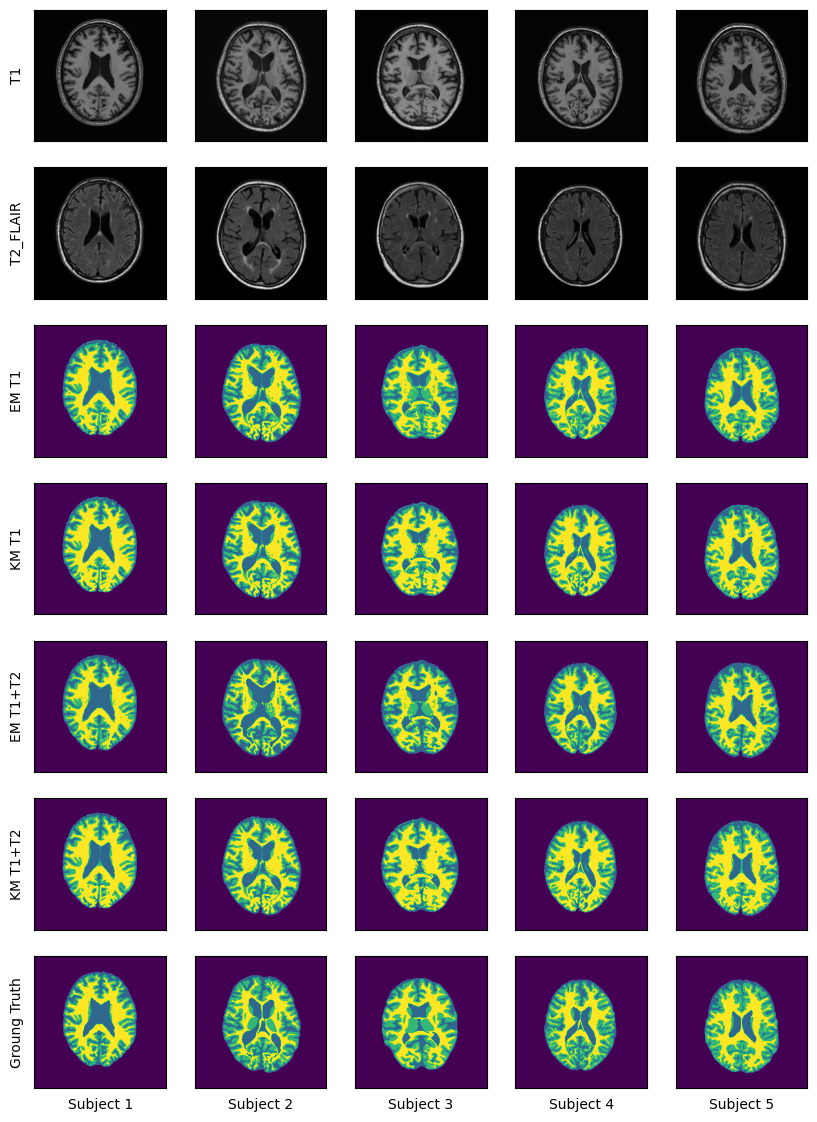

In [60]:
img_names = [
    'T1.nii', 'T2_FLAIR.nii', 'em_seg_t1.nii', 'km_seg_t1.nii',
    'em_seg_t1_t2.nii', 'km_seg_t1_t2.nii', 'LabelsForTesting.nii'
]
ylabels = [
    'T1', 'T2_FLAIR', 'EM T1', 'KM T1',
    'EM T1+T2', 'KM T1+T2', 'Groung Truth'
]
complete_figure(img_names, ylabels, slice_n = 25)

In [61]:
df = pd.melt(dice_scores, id_vars=['modalities', 'subject', 'model', 'time'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df['model'] = df['model'].str.upper()
df.columns = ['Modalities', 'Subject', 'Model', 'Time', 'Tissue', 'Dice']

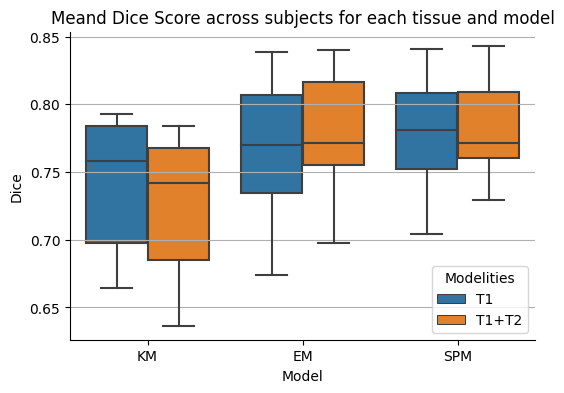

In [62]:
plt.figure(figsize=(6,4))
plt.title('Meand Dice Score across subjects for each tissue and model')
sns.boxplot(data=df, x="Model", y="Dice", hue="Modalities")
sns.despine()
plt.grid(axis='y')
plt.legend(loc='lower right', title='Modelities')
plt.show()

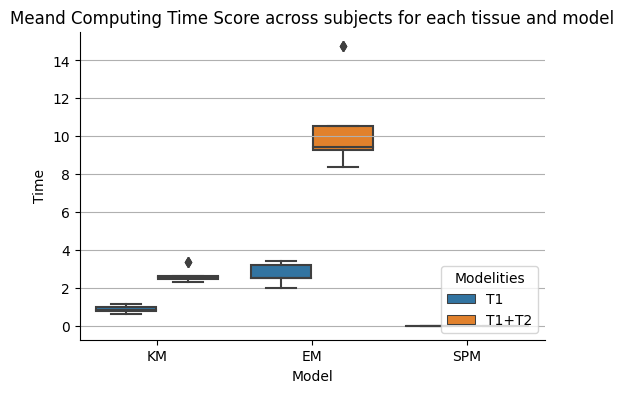

In [63]:
plt.figure(figsize=(6,4))
plt.title('Meand Computing Time Score across subjects for each tissue and model')
sns.boxplot(data=df, x="Model", y="Time", hue="Modalities")
sns.despine()
plt.grid(axis='y')
plt.legend(loc='lower right', title='Modelities')
plt.show()

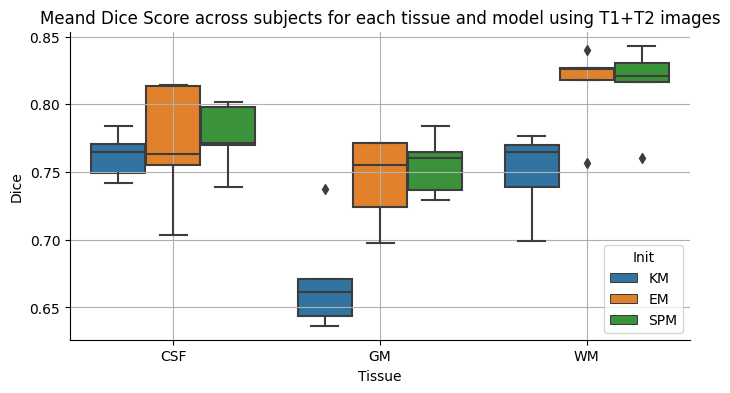

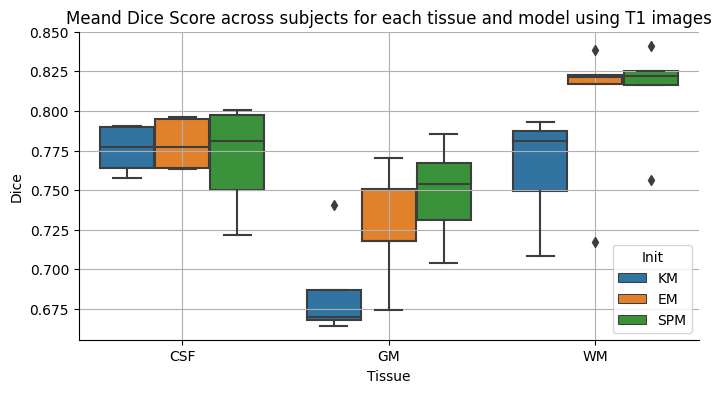

In [64]:
df_ = df.loc[df.Modalities == 'T1+T2']
plt.figure(figsize=(8,4))
plt.title('Meand Dice Score across subjects for each tissue and model using T1+T2 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Init')
plt.show()

df_ = df.loc[df.Modalities == 'T1']
plt.figure(figsize=(8,4))
plt.title('Meand Dice Score across subjects for each tissue and model using T1 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Init')
plt.show()